In [1]:
from __future__ import annotations

from dataclasses import dataclass
from pathlib import Path
from typing import Tuple

import numpy as np
import matplotlib.pyplot as plt
import tifffile as tiff


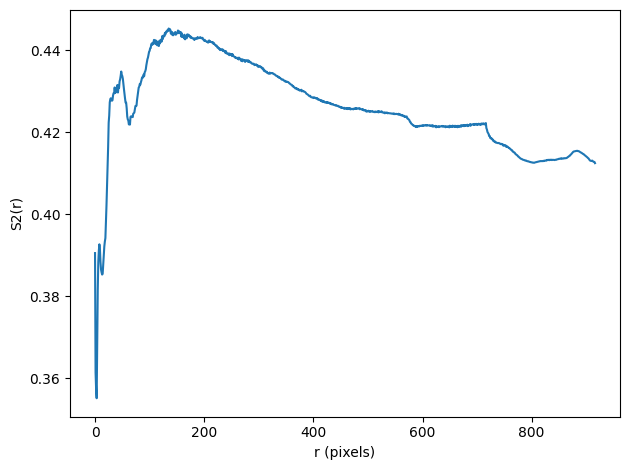

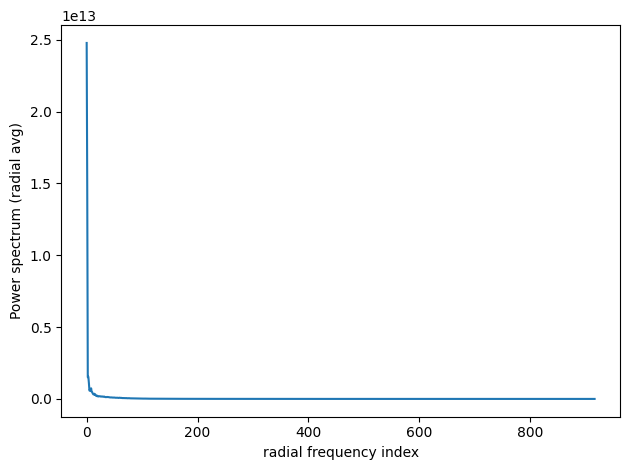

Image: pictures\260558_1 (1).tif
Loaded shape/dtype: (1144, 1434, 3) uint8
Saved: run_pic\260558_1 (1)_S2_radial.csv
Saved: run_pic\260558_1 (1)_PSD_radial.csv
Saved plots in: C:\2026-python\cancerpicture\Fiji\run_pic\run_pic
Mask area fraction phi = 0.6429


In [2]:


# ----------------------------
# Core math: S2 (2-point correlation) <-> FFT power spectrum
# ----------------------------

def rgb_to_gray(img: np.ndarray) -> np.ndarray:
    """RGB -> grayscale (float32)."""
    if img.ndim != 3 or img.shape[-1] < 3:
        return img.astype(np.float32, copy=False)
    r, g, b = img[..., 0], img[..., 1], img[..., 2]
    return (0.2126 * r + 0.7152 * g + 0.0722 * b).astype(np.float32, copy=False)


def otsu_threshold(x: np.ndarray) -> float:
    """Otsu threshold for 2D grayscale."""
    x = x.astype(np.float32, copy=False)
    x = x[np.isfinite(x)]
    if x.size == 0:
        return 0.0
    lo, hi = float(x.min()), float(x.max())
    if hi <= lo:
        return lo

    hist, edges = np.histogram(x, bins=256, range=(lo, hi))
    hist = hist.astype(np.float64)
    p = hist / np.maximum(hist.sum(), 1.0)
    omega = np.cumsum(p)
    centers = (edges[:-1] + edges[1:]) / 2.0
    mu = np.cumsum(p * centers)
    mu_t = mu[-1]
    sigma_b2 = (mu_t * omega - mu) ** 2 / (omega * (1.0 - omega) + 1e-12)
    idx = int(np.nanargmax(sigma_b2))
    return float(centers[idx])


def fft_autocorr_unbiased(f: np.ndarray, pad: bool = True) -> np.ndarray:
    """
    Unbiased autocorrelation via FFT.

    pad=True reduces wrap-around artifacts by zero-padding to 2x size.
    Returns autocorr with zero-shift at (0,0) (use fftshift for centering).
    """
    f = np.asarray(f, dtype=np.float32)
    if f.ndim != 2:
        raise ValueError("f must be 2D")

    h, w = f.shape
    if pad:
        H, W = 2 * h, 2 * w
        fp = np.zeros((H, W), dtype=np.float32)
        fp[:h, :w] = f
        ones = np.zeros((H, W), dtype=np.float32)
        ones[:h, :w] = 1.0
    else:
        fp = f
        ones = np.ones_like(f, dtype=np.float32)

    F = np.fft.fft2(fp)
    auto = np.fft.ifft2(F * np.conj(F)).real

    O = np.fft.ifft2(np.fft.fft2(ones) * np.conj(np.fft.fft2(ones))).real
    auto /= np.maximum(O, 1e-12)

    return auto[:h, :w]  # crop back


def radial_average(img: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """Radial average around image center."""
    h, w = img.shape
    cy, cx = (h - 1) / 2.0, (w - 1) / 2.0
    y, x = np.indices((h, w))
    r = np.sqrt((y - cy) ** 2 + (x - cx) ** 2).astype(np.float32)

    r_int = r.astype(np.int32)
    max_r = int(r_int.max())

    sums = np.bincount(r_int.ravel(), weights=img.ravel(), minlength=max_r + 1)
    cnts = np.bincount(r_int.ravel(), minlength=max_r + 1)
    prof = sums / np.maximum(cnts, 1)

    return np.arange(max_r + 1, dtype=np.float32), prof.astype(np.float32)


@dataclass(frozen=True)
class Results:
    r_px: np.ndarray
    s2_r: np.ndarray
    k_idx: np.ndarray
    psd_k: np.ndarray
    phi: float


def analyze_image(
    tif_path: Path,
    outdir: Path,
    mode: str = "binary_otsu",
    invert: bool = False,
    pad: bool = True,
) -> Results:
    """
    mode:
      - binary_otsu: grayscale -> Otsu -> mask f∈{0,1}, compute S2
      - gray_centered: grayscale -> mean-center, compute C (autocov)
    """
    outdir.mkdir(parents=True, exist_ok=True)

    img = tiff.imread(str(tif_path))
    x = rgb_to_gray(img)
    if invert:
        x = x.max() - x

    if mode == "binary_otsu":
        thr = otsu_threshold(x)
        f = (x >= thr).astype(np.float32)
        phi = float(f.mean())

        s2 = fft_autocorr_unbiased(f, pad=pad)
        s2c = np.fft.fftshift(s2)
        r_px, s2_r = radial_average(s2c)
        s2_name = "S2"
    elif mode == "gray_centered":
        g = x - float(np.mean(x))
        phi = float(np.mean(x))

        c = fft_autocorr_unbiased(g, pad=pad)
        cc = np.fft.fftshift(c)
        r_px, s2_r = radial_average(cc)
        s2_name = "C"
    else:
        raise ValueError("Unknown mode")

    # PSD: |FFT(g)|^2 (use mean-centered grayscale for frequency analysis)
    g = x - float(np.mean(x))
    G = np.fft.fft2(g)
    psd = (np.abs(G) ** 2).astype(np.float32)
    psdc = np.fft.fftshift(psd)
    k_idx, psd_k = radial_average(psdc)

    # Save CSVs
    s2_csv = outdir / f"{tif_path.stem}_{s2_name}_radial.csv"
    psd_csv = outdir / f"{tif_path.stem}_PSD_radial.csv"
    np.savetxt(s2_csv, np.c_[r_px, s2_r], delimiter=",", header="r_px,profile", comments="")
    np.savetxt(psd_csv, np.c_[k_idx, psd_k], delimiter=",", header="k_index,psd", comments="")

    # Plots
    plt.figure()
    plt.plot(r_px, s2_r)
    plt.xlabel("r (pixels)")
    plt.ylabel("S2(r)" if mode == "binary_otsu" else "C(r)")
    plt.tight_layout()
    plt.savefig(outdir / f"{tif_path.stem}_{s2_name}.png", dpi=200)
    plt.show()

    plt.figure()
    plt.plot(k_idx, psd_k)
    plt.xlabel("radial frequency index")
    plt.ylabel("Power spectrum (radial avg)")
    plt.tight_layout()
    plt.savefig(outdir / f"{tif_path.stem}_PSD.png", dpi=200)
    plt.show()

    print("Image:", tif_path)
    print("Loaded shape/dtype:", img.shape, img.dtype)
    print("Saved:", s2_csv)
    print("Saved:", psd_csv)
    print("Saved plots in:", outdir.resolve())
    if mode == "binary_otsu":
        print(f"Mask area fraction phi = {phi:.4f}")

    return Results(r_px=r_px, s2_r=s2_r, k_idx=k_idx, psd_k=psd_k, phi=phi)


# ----------------------------
# Run (edit paths if needed)
# ----------------------------

project_root = Path(".")
tif_path = project_root / "pictures" / "260558_1 (1).tif"
outdir = project_root / "run_pic"

res = analyze_image(
    tif_path=tif_path,
    outdir=outdir,
    mode="binary_otsu",   # 练习先用这个
    invert=False,         # 如果你发现“目标是暗的”，改 True
    pad=True,             # 建议 True，减少边界环绕伪影
)
